In [1]:
%matplotlib inline


# Transfer Learning for Computer Vision Tutorial

adapted from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

**Author**: [Sasank Chilamkurthy](https://chsasank.github.io)

In this tutorial, you will learn how to train a convolutional neural network for
image classification using transfer learning. You can read more about the transfer
learning at [cs231n notes](https://cs231n.github.io/transfer-learning/)_

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initialization, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.


In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

from torch.utils.tensorboard import SummaryWriter

cudnn.benchmark = True
plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Load Data

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   [here](https://download.pytorch.org/tutorial/hymenoptera_data.zip)
   and extract it to the current directory.



In [3]:
# getting the dataset in 
#!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip

# unzipping the dataset 
#!unzip hymenoptera_data.zip

data_dir = 'hymenoptera_data'

In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [5]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

### Visualize a few images
Let's visualize a few training images so as to understand the data
augmentations.



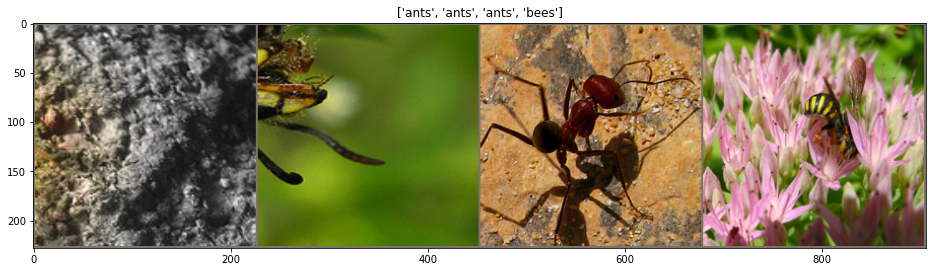

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0)) # (C H W) -> (H, W, C) 
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(16,12))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training the model

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    tb_writer = SummaryWriter()

    train_loss, val_loss = list(), list()
    train_acc, val_acc = list(), list()
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                train_loss_epoch = epoch_loss
                train_acc_epoch = epoch_acc
            else: 
                val_loss_epoch = epoch_loss
                val_acc_epoch = epoch_acc

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        train_loss.append(train_loss_epoch)
        train_acc.append(train_acc_epoch.cpu())
        val_loss.append(val_loss_epoch)
        val_acc.append(val_acc_epoch.cpu())

        tags = ["train_loss", "train_acc", "val_loss", "val_acc"]
        tb_writer.add_scalar(tags[0], train_loss_epoch, epoch)
        tb_writer.add_scalar(tags[1], train_acc_epoch, epoch)
        tb_writer.add_scalar(tags[2], val_loss_epoch, epoch)
        tb_writer.add_scalar(tags[3], val_acc_epoch, epoch)
        
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')    
    print(f'Best val Acc: {best_acc:4f}')
    
    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, (train_loss, train_acc, val_loss, val_acc)

### Visualizing the model predictions

Generic function to display predictions for a few images




In [8]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [9]:
def plot_curve(train_loss, train_acc, val_loss, val_acc):
    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    plt.title("Train-Validation Loss")
    plt.plot(train_loss, label='train')
    plt.plot(val_loss, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('accuracy', fontsize=12)
    plt.legend(loc='best')
    
    plt.subplot(1,2,2)
    plt.title("Train-Validation Accuracy")
    plt.plot(train_acc, label='train')
    plt.plot(val_acc, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('accuracy', fontsize=12)
    plt.legend(loc='best')



## Finetuning the convnet

Load a pretrained model and reset final fully connected layer.


The model used in this tutorial is Resnet18. It is first proposed in the [Deep Residual Learning for Image Recognition paper by He et al.](https://arxiv.org/pdf/1512.03385.pdf).
The pretrained ResNet18 model is detailed in 
https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html

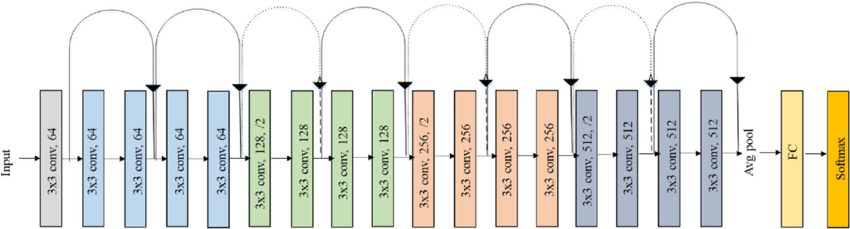


In [10]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# add a fully-connected layer for classification, specifying the classes(2) and number of features (512)
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### Train and evaluate

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [12]:
model_ft,(train_loss, train_acc, val_loss, val_acc) = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6218 Acc: 0.7131
val Loss: 0.2461 Acc: 0.8758

Epoch 1/24
----------
train Loss: 0.5868 Acc: 0.7254
val Loss: 0.3778 Acc: 0.8889

Epoch 2/24
----------
train Loss: 0.5736 Acc: 0.7787
val Loss: 0.4329 Acc: 0.8301

Epoch 3/24
----------
train Loss: 0.4422 Acc: 0.8074
val Loss: 0.2699 Acc: 0.8758

Epoch 4/24
----------
train Loss: 0.6858 Acc: 0.7295
val Loss: 0.4429 Acc: 0.8497

Epoch 5/24
----------
train Loss: 0.5626 Acc: 0.7992
val Loss: 0.3347 Acc: 0.8693

Epoch 6/24
----------
train Loss: 0.4301 Acc: 0.8197
val Loss: 0.3393 Acc: 0.8824

Epoch 7/24
----------
train Loss: 0.4330 Acc: 0.8402
val Loss: 0.3219 Acc: 0.8889

Epoch 8/24
----------
train Loss: 0.4575 Acc: 0.8320
val Loss: 0.2869 Acc: 0.8824

Epoch 9/24
----------
train Loss: 0.3598 Acc: 0.8566
val Loss: 0.2777 Acc: 0.8758

Epoch 10/24
----------
train Loss: 0.3522 Acc: 0.8484
val Loss: 0.2291 Acc: 0.9020

Epoch 11/24
----------
train Loss: 0.3241 Acc: 0.8566
val Loss: 0.2511 Acc: 0.8954

Ep

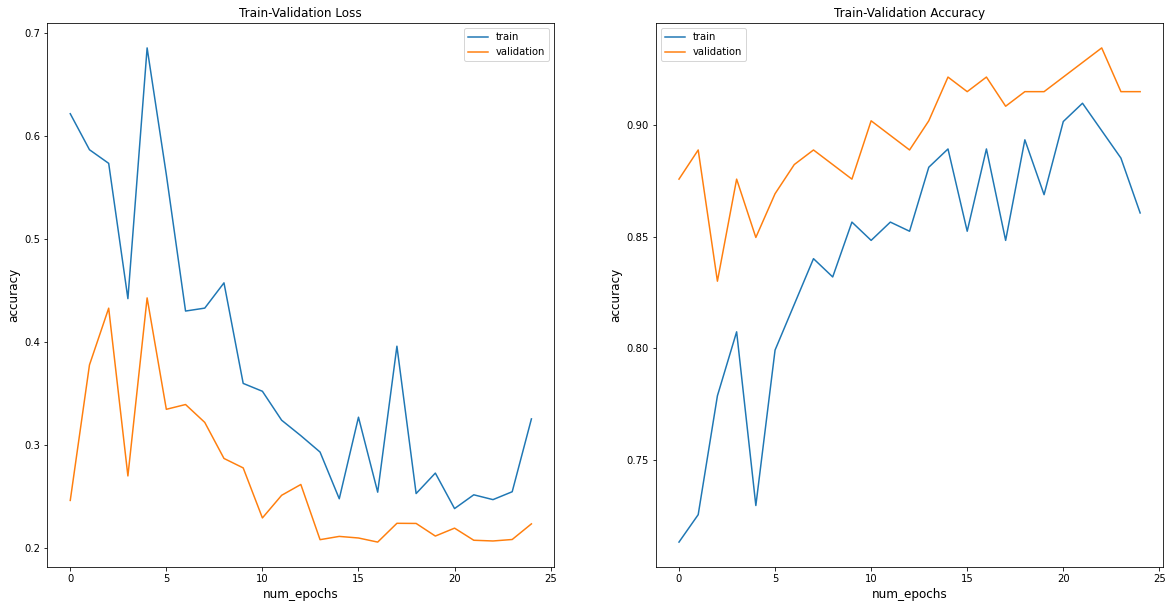

In [13]:
plot_curve(train_loss, train_acc, val_loss, val_acc)

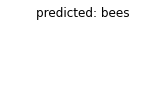

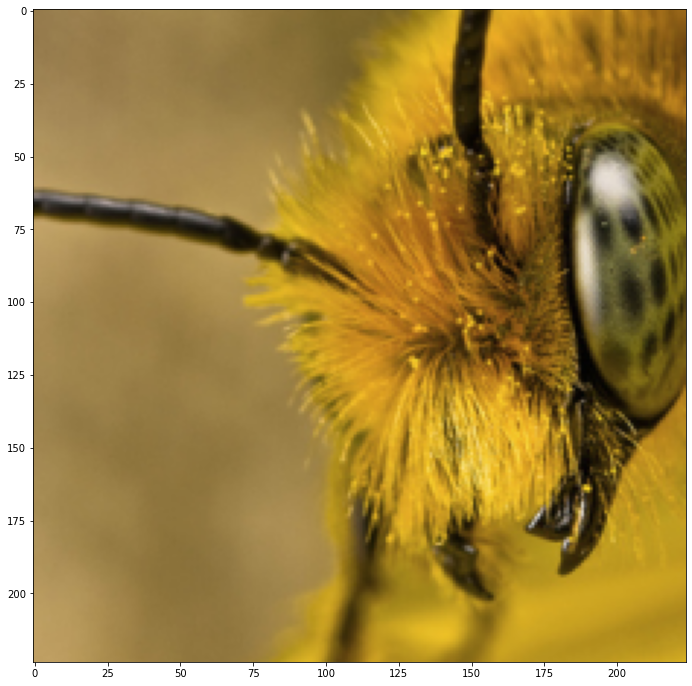

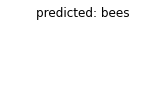

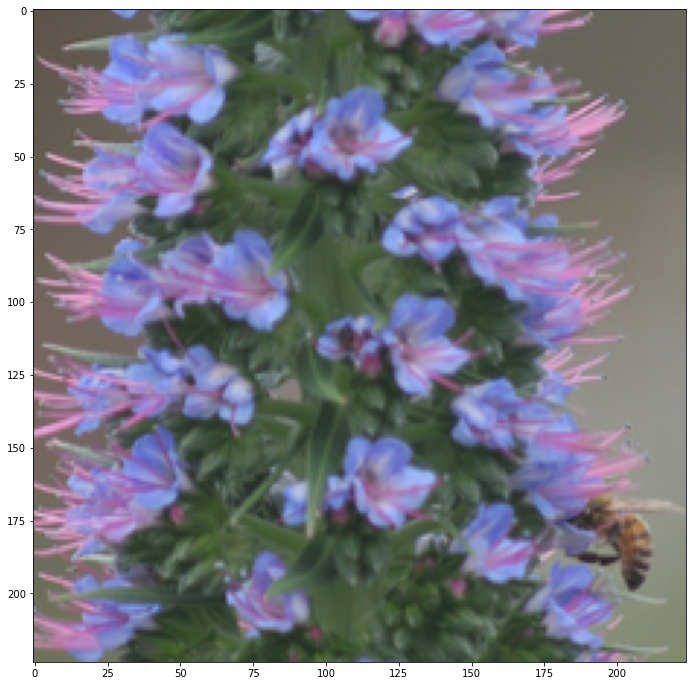

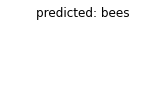

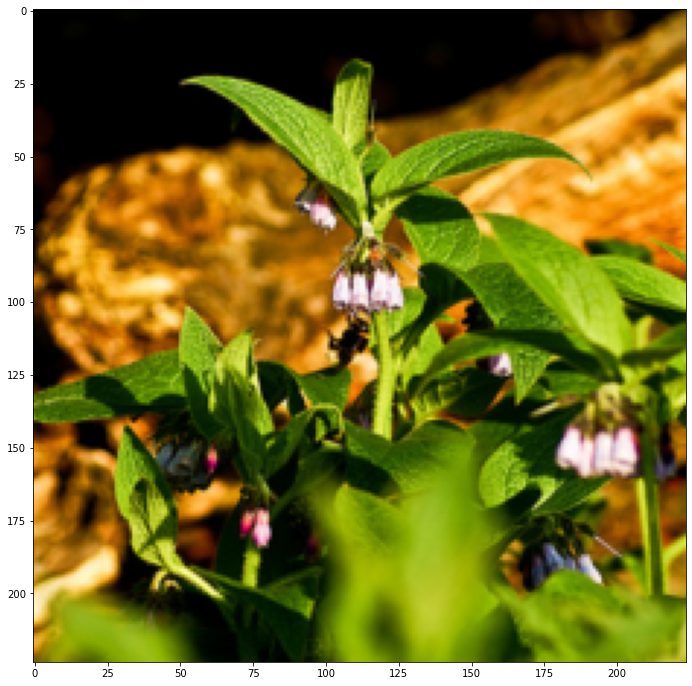

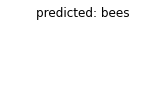

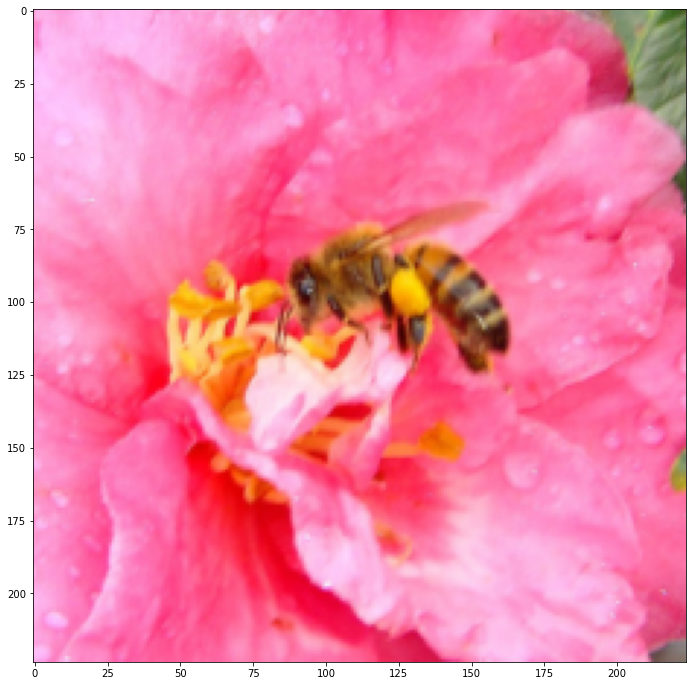

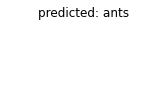

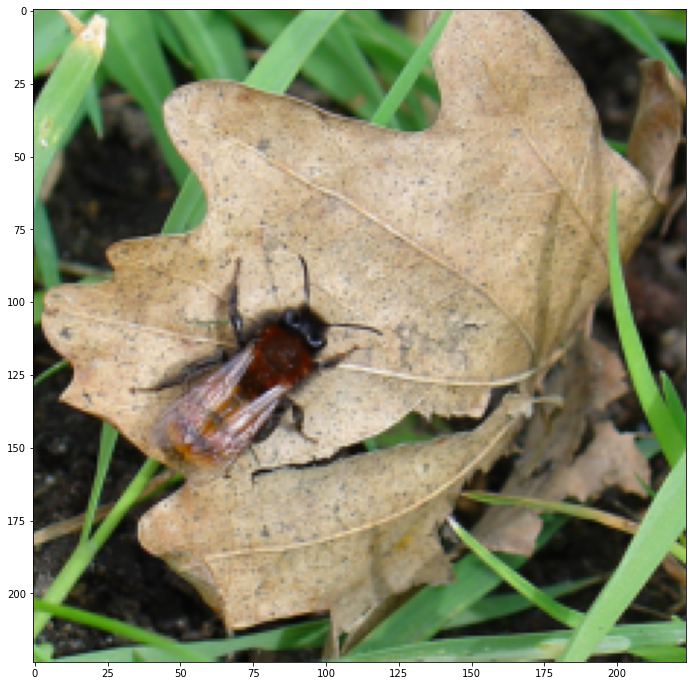

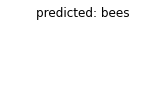

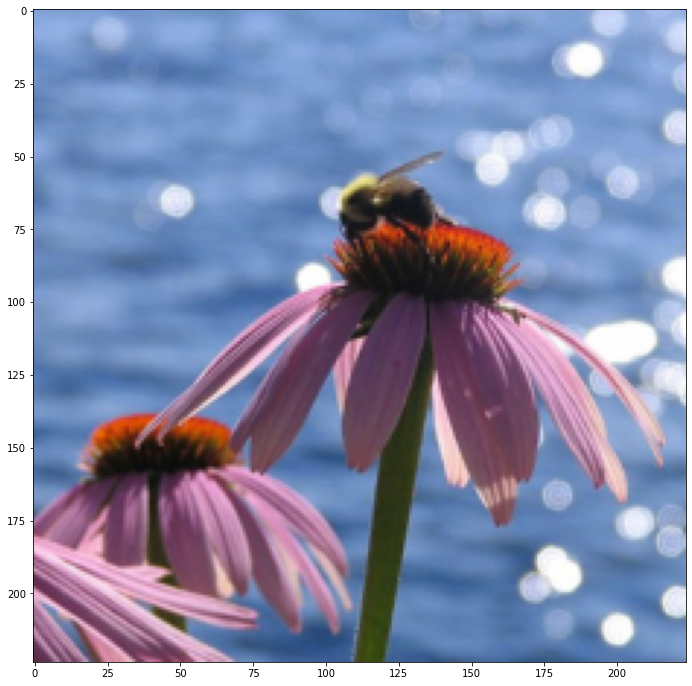

In [14]:
visualize_model(model_ft)

## ConvNet as fixed feature extractor

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad = False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
[here](https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward)_.




In [19]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### Train and evaluate

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [20]:
model_conv, (train_loss, train_acc, val_loss, val_acc) = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7172 Acc: 0.6230
val Loss: 0.2660 Acc: 0.9085

Epoch 1/24
----------
train Loss: 0.4605 Acc: 0.7500
val Loss: 0.1848 Acc: 0.9477

Epoch 2/24
----------
train Loss: 0.4312 Acc: 0.8074
val Loss: 0.1672 Acc: 0.9477

Epoch 3/24
----------
train Loss: 0.4555 Acc: 0.8156
val Loss: 0.3048 Acc: 0.8889

Epoch 4/24
----------
train Loss: 0.5028 Acc: 0.8074
val Loss: 0.2899 Acc: 0.8889

Epoch 5/24
----------
train Loss: 0.4587 Acc: 0.7746
val Loss: 0.2126 Acc: 0.9216

Epoch 6/24
----------
train Loss: 0.5333 Acc: 0.7705
val Loss: 0.4360 Acc: 0.8431

Epoch 7/24
----------
train Loss: 0.3517 Acc: 0.8689
val Loss: 0.2077 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.3026 Acc: 0.8566
val Loss: 0.1878 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.3313 Acc: 0.8648
val Loss: 0.1950 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.2911 Acc: 0.8730
val Loss: 0.1784 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3275 Acc: 0.8566
val Loss: 0.2136 Acc: 0.9216

Ep

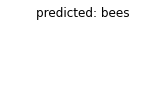

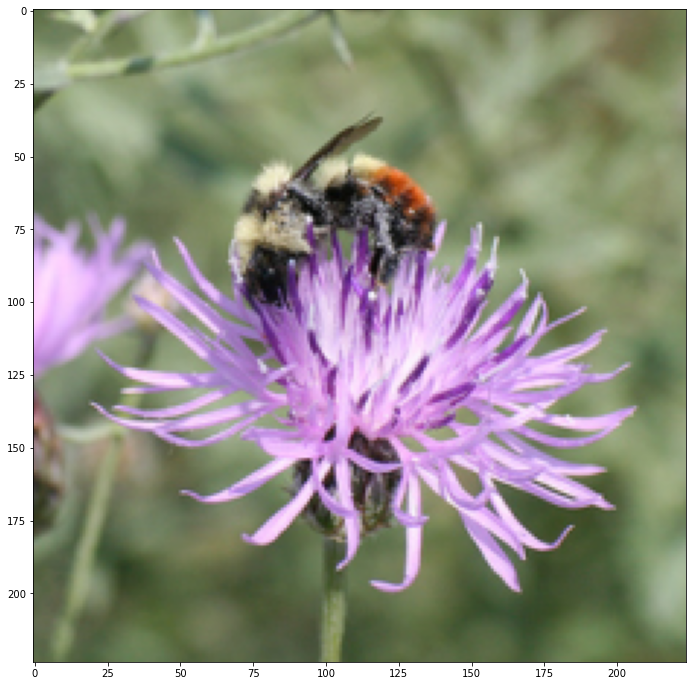

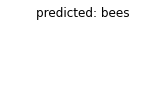

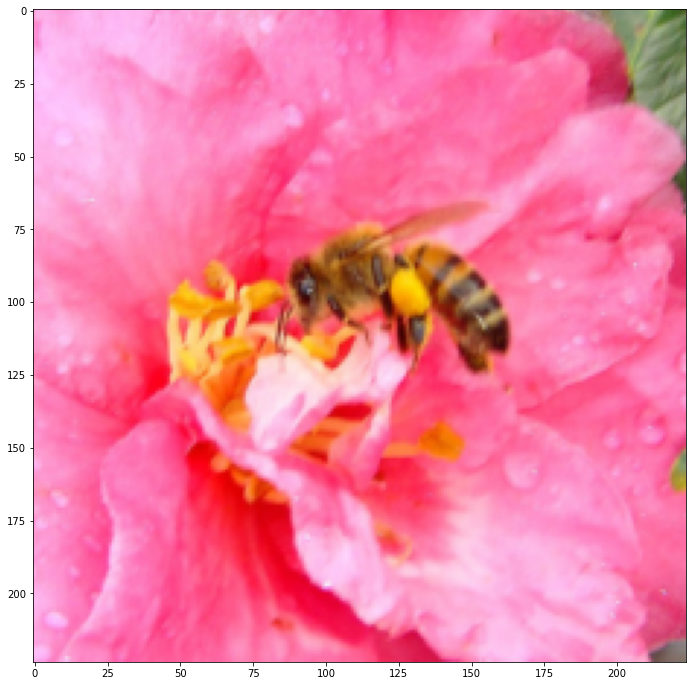

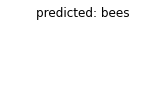

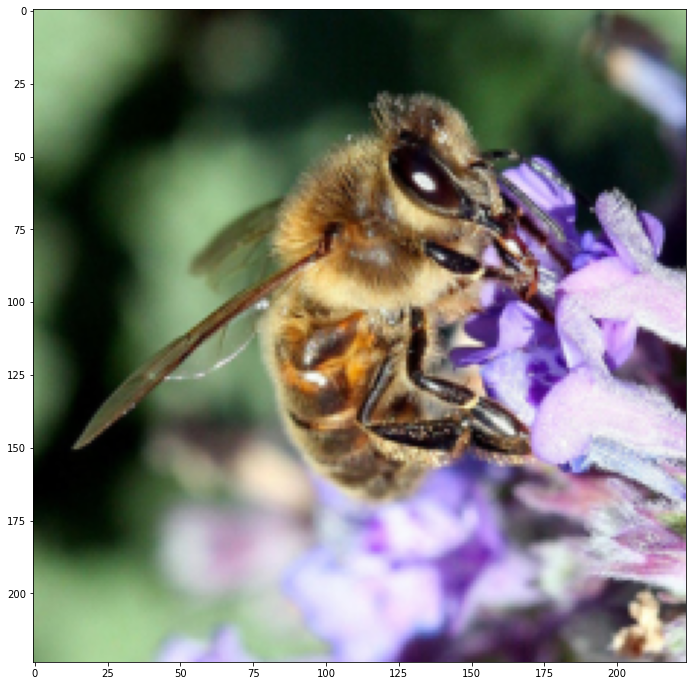

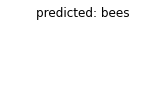

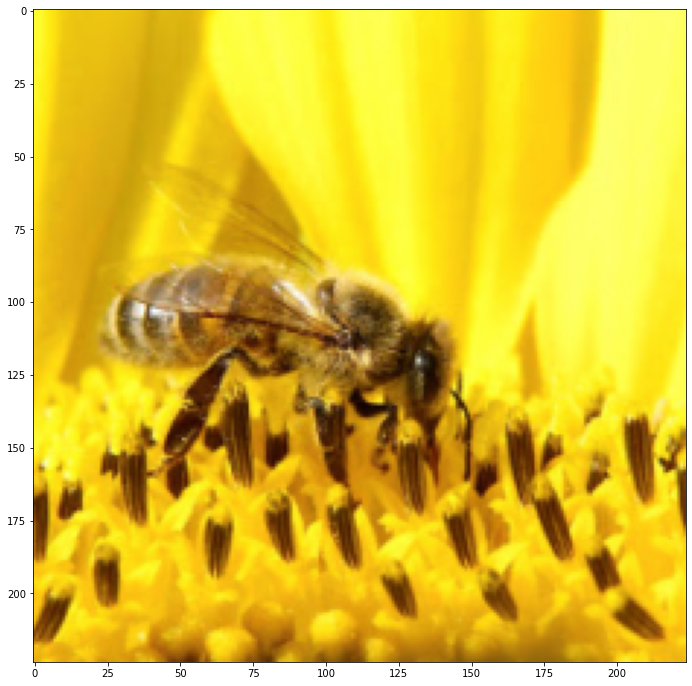

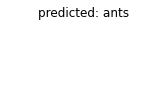

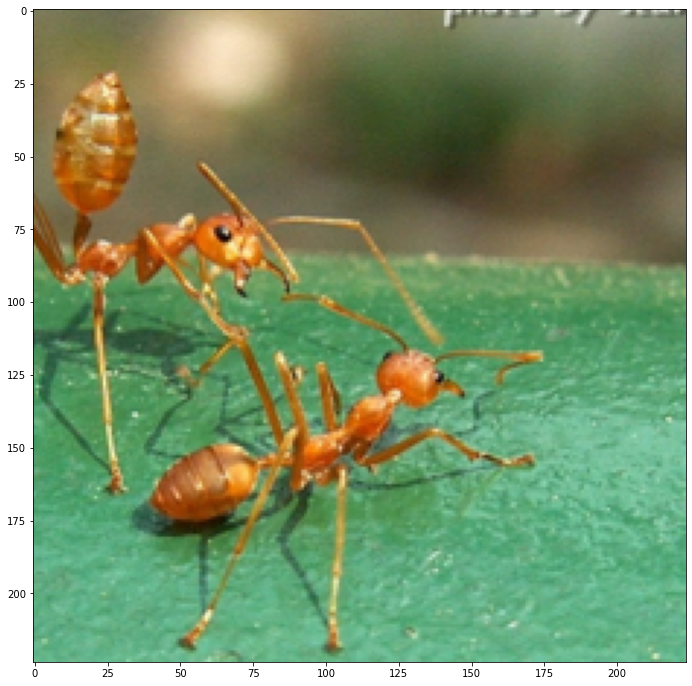

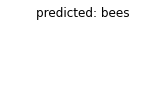

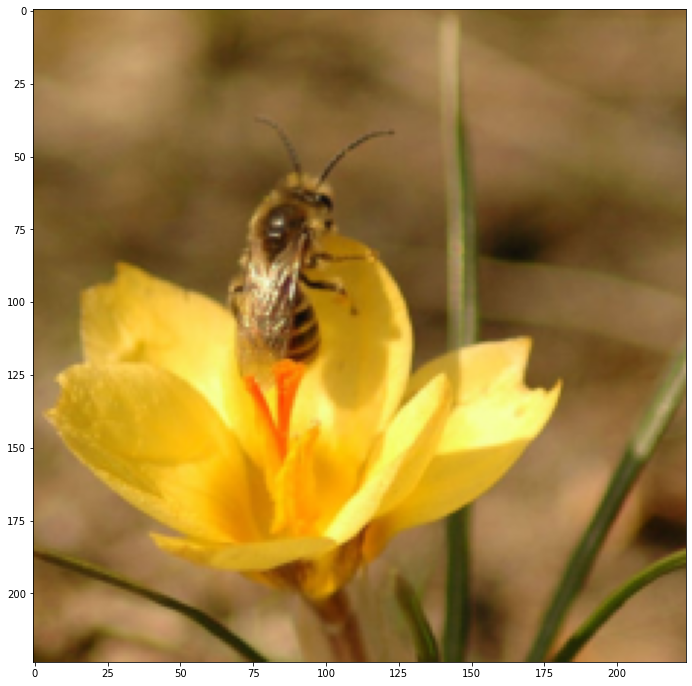

In [21]:
visualize_model(model_conv)

In [ ]:

plt.ioff()
plt.show()

## Further Learning

If you would like to learn more about the applications of transfer learning,
checkout our [Quantized Transfer Learning for Computer Vision Tutorial](https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html).



